## AFL Random Forest Prediction

We shall use a random forest classifier to predict the outcome of an AFL match based on a number of match statistics.

Data has beeen extracted from afltables.com using the 'FitzRoy' R package and further statistics calculated using Pandas.

### Data Preparation
First, we will read in the data and remove the columns that we won't use in our predicitons.

We will also change the date column to the correct dtype and remove NA values.

For simplicity, we will remove the matches that result in a draw. This happens rarely, so we don't lose much by not having our algorithm predict a draw.

We will also give the target column a numeric value: 1 means the home team won and 0 means the away team won.

In [3]:
import pandas as pd

In [39]:
afl_df = pd.read_csv('afl_stats.csv')
afl_df = afl_df.drop(["Game", "Season", "Round", "Home_Team", "Home_PointsBy", "AwayTeam", "AwayPointsBy"], axis=1)
afl_df["Date"] = pd.to_datetime(afl_df["Date"])
afl_df = afl_df.dropna()
afl_df = afl_df[afl_df["Winner"] != "Draw"]
afl_df["Winner"] = (afl_df["Winner"] == "Home").astype("int")

### Building the Model

Start by importing the functions we need from sklearn.


In [8]:
import numpy as np

Initialise the random forest classifier.

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

Split the data into a training set and test set.

The training set will consist of games that occured before 2020.

In [41]:
train = afl_df["Date"] < '2020-01-01'
trainX = afl_df.loc[train, ~afl_df.columns.isin(["Winner", "Date"])]
trainY = afl_df.loc[train, "Winner"]
testX = afl_df.loc[~train, ~afl_df.columns.isin(["Winner", "Date"])]
testY = afl_df.loc[~train, "Winner"]

Fit the random forest to our training data.

In [11]:
rf.fit(trainX, trainY)

RandomForestClassifier()

### Measuring Accuracy

Get the predictions for the test data and calculate the accuracy.

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
def evaluate_model(model, testX, testY):
    preds = model.predict(testX)    
    acc = accuracy_score(testY, preds)*100
    print("Accuracy = {:0.2f}%".format(acc))

In [15]:
evaluate_model(rf, testX, testY)

Accuracy = 63.16%


Let's try cross validation:

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
scores = cross_val_score(rf, trainX, trainY, cv = 10)


In [19]:
print(scores)
np.mean(scores)

[0.66753247 0.63896104 0.64155844 0.66233766 0.63636364 0.67708333
 0.69010417 0.6328125  0.6328125  0.62239583]


0.650196158008658

## Parameter Tuning

Try a grid search to find the optimal parameters in our random forest model.

In [59]:
from sklearn.model_selection import RandomizedSearchCV

In [60]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(trainX, trainY)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\tomdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [61]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [81]:
best_rf = rf_random.best_estimator_

Accuracy = 66.49%


In [88]:
evaluate_model(best_rf, testX, testY)

Accuracy = 66.49%


In [1]:
scores = cross_val_score(rf, trainX, trainY, cv = 10)

NameError: name 'cross_val_score' is not defined

In [84]:
print("CV Accuracy = {:0.2f}%".format(np.mean(scores)*100))

CV Accuracy = 65.08%


Now we will use a grid search to tune the model more finely, based on the best estimator obtained from the randomized grid search.

In [13]:
param_grid = {'bootstrap': [True, False],
              'max_depth': [5, 10, 15],
              'min_samples_leaf': [3, 4, 6],
              'min_samples_split': [3, 5, 7],
              'n_estimators': [50, 100, 150, 200, 250, 300]}

In [3]:
from sklearn.model_selection import GridSearchCV

In [14]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv = 5, return_train_score = True)
grid_search.fit(trainX, trainY)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'min_samples_leaf': [3, 4, 6],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             return_train_score=True)

In [17]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 6,
 'min_samples_split': 3,
 'n_estimators': 150}

In [18]:
best_rf = grid_search.best_estimator_

In [21]:
evaluate_model(best_rf, testX, testY)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AwayPerformance_Last_1
- AwayPerformance_Last_2
- AwayPerformance_Last_3
- AwayPerformance_Last_4
- AwayPerformance_Last_5
- ...
Feature names seen at fit time, yet now missing:
- Away_Performance
- Away_Points_Against
- Away_Points_Against_1
- Away_Points_Against_2
- Away_Points_Against_3
- ...


In [27]:
scores = cross_val_score(best_rf, trainX, trainY, cv = 10)

In [30]:
print("CV Accuracy = {:0.2f}%".format(np.mean(scores)*100))

CV Accuracy = 65.34%


So this is very slightly better, but not significantly.

## Saving Model

Save the model for later use:

In [31]:
import joblib
joblib.dump(best_rf, "afl_rf2.pkl")


['afl_rf2.pkl']

Load the model:

In [87]:
best_rf = joblib.load("afl_rf.pkl")

In [20]:
import joblib
best_rf = joblib.load("afl_rf2.pkl")

In [24]:
bestParams = {'bootstrap': True,
              'max_depth': 10,
              'min_samples_leaf': 6,
              'min_samples_split': 3,
              'n_estimators': 150}
rf = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_leaf=6, min_samples_split=3, bootstrap=True)

In [42]:
rf.fit(trainX, trainY)

RandomForestClassifier(max_depth=10, min_samples_leaf=6, min_samples_split=3,
                       n_estimators=150)

In [43]:
evaluate_model(rf, testX, testY)

Accuracy = 64.56%


In [44]:
scores = cross_val_score(rf, trainX, trainY, cv = 10)
np.mean(scores)

0.6525446428571429

In [28]:
afl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4415 entries, 8 to 4462
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       4415 non-null   datetime64[ns]
 1   Winner                     4415 non-null   int32         
 2   Home_SeasonPointsBy        4415 non-null   int64         
 3   Home_SeasonPointsAgainst   4415 non-null   int64         
 4   Home_SeasonPerformance     4415 non-null   int64         
 5   Home_Ranking               4415 non-null   float64       
 6   Home_PointsBy_Last_1       4415 non-null   float64       
 7   Home_PointsAgainst_Last_1  4415 non-null   float64       
 8   Home_Performance_Last_1    4415 non-null   float64       
 9   Home_PointsBy_Last_2       4415 non-null   float64       
 10  Home_PointsAgainst_Last_2  4415 non-null   float64       
 11  Home_Performance_Last_2    4415 non-null   float64       
 12  Home_P

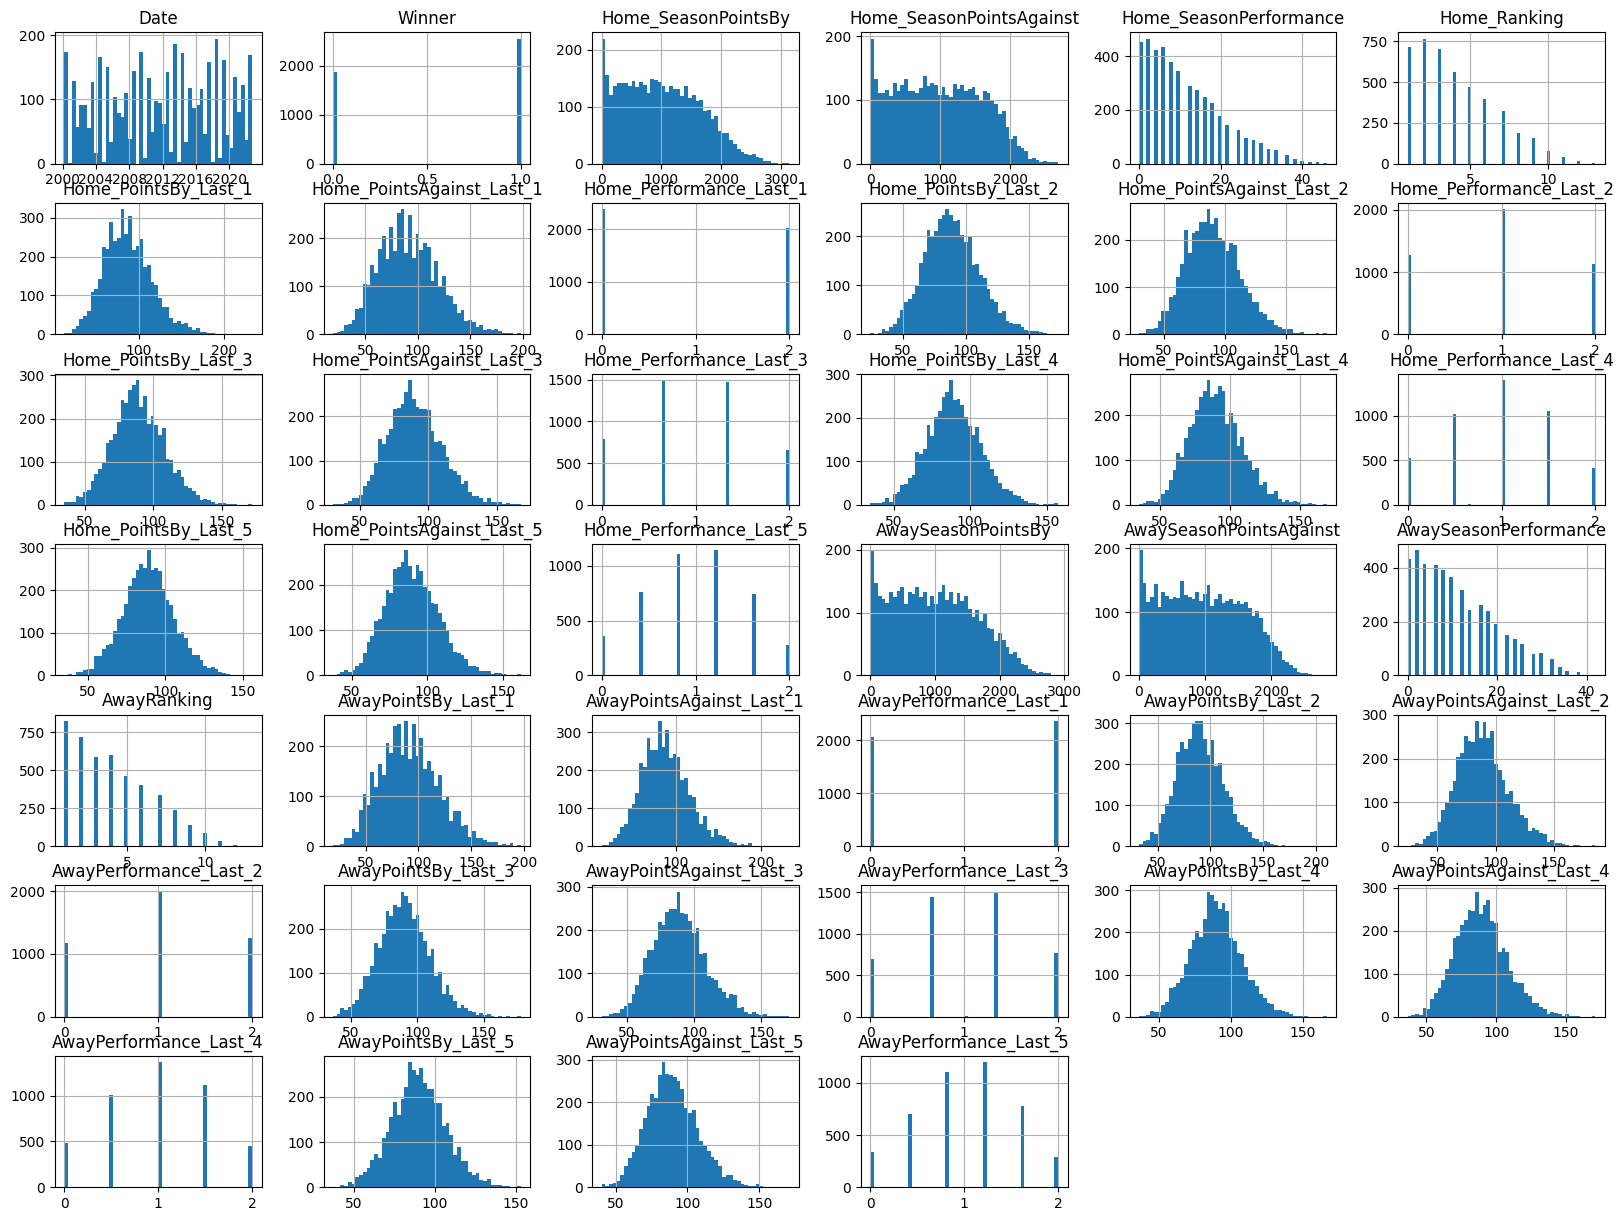

In [30]:
import matplotlib.pyplot as plt
afl_df.hist(bins=50, figsize=(20,15))
plt.show()